In [1]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()

--2024-11-04 03:02:44--  https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7171 (7.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   7.00K  --.-KB/s    in 0s      

2024-11-04 03:02:44 (30.2 MB/s) - ‘helper.py’ saved [7171/7171]

Installing idaes via pip...
idaes was successfully installed
Running idaes get-extensions to install Ipopt, k_aug, and more...
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)

[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions

In [2]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np

In [3]:
def delete_component(Model, comp_name):

        list_del = [vr for vr in vars(Model)
                    if comp_name == vr
                    or vr.startswith(comp_name + '_index')
                    or vr.startswith(comp_name + '_domain')]

        list_del_str = ', '.join(list_del)
        print('Deleting model components ({}).'.format(list_del_str))

        for kk in list_del:
            Model.del_component(kk)

In [4]:
solver = SolverFactory('ipopt')

# Crear el modelo concreto
Model = ConcreteModel()

# Definimos a entre 0 y 350
Model.a = Var(domain=NonNegativeReals, bounds=(0, 350))

Model.v = Var(domain=Reals)
Model.b = Var(domain=Reals)

# Definir restricciones
def ventas_unitarias_rule(model):
    return model.v == 890 - 3.8*model.a + 20*(model.a + 1e-5)**0.5

def beneficio_rule(model):
    return model.b == -1.444*(model.a**2) + 7.6*((model.a + 1e-5)**1.5) + 80*((model.a + 1e-5)**0.5) + 322*model.a + 3560

# Añadir restricciones
Model.ventas_unitarias_constr = Constraint(rule=ventas_unitarias_rule)
Model.beneficio_constr = Constraint(rule=beneficio_rule)

# Definir una función de objetivo que maximice el beneficio
Model.max_b = Objective(expr=Model.b, sense=maximize)

# Resolver el modelo una vez para obtener el valor máximo y mínimo de b
solver.solve(Model)
max_b = Model.b.value
min_v = Model.v.value

# Borrar el objetivo actual
delete_component(Model, 'max_b')

# Definir una función de objetivo que maximice ventas unitarias
Model.max_v = Objective(expr=Model.v, sense=maximize)
solver.solve(Model)
min_b = Model.b.value
max_v = Model.v.value

# Borrar el objetivo actual
delete_component(Model, 'max_v')

# Definir una función de objetivo que maximice ventas unitarias
Model.max_b = Objective(expr=Model.v, sense=maximize)

pareto = []

# Crearpesos
w = np.linspace(0, 1, 10)

# E constr
for i in w:
    if i == 0:
        Model.restr = Constraint(expr=Model.b >= (max_b - i*(max_b - min_b)))
    else:
        delete_component(Model, 'restr')
    Model.restr = Constraint(expr=Model.b >= (max_b - i*(max_b - min_b)))
    solver.solve(Model)
    print(Model.b.value, Model.v.value)
    pareto.append((Model.b.value, Model.v.value))

# Convertir los resultados de Pareto en arrays
pareto = np.array(pareto)

#print(max_b,min_b)
#print(max_v,min_v)
#print(pareto)

Deleting model components (max_b).


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Deleting model components (max_v).
34517.67728422138 526.074151000724
Deleting model components (restr).
31356.790053928213 676.2589397122315
Deleting model components (restr).
28195.902823576635 736.0863345879918
Deleting model components (restr).
25035.015593217788 780.493387941145
Deleting model components (restr).
21874.128362857806 816.4973428987458
Deleting model components (restr).
18713.24113250123 846.6682252572015
Deleting model components (restr).
15552.353902155195 872.1019682936137
Deleting model components (restr).
12391.466671838452 893.0620497425506
Deleting model components (restr).
9230.579441640295 908.8763874509754
Deleting model components (restr).
6069.735098328672 916.3158274732326


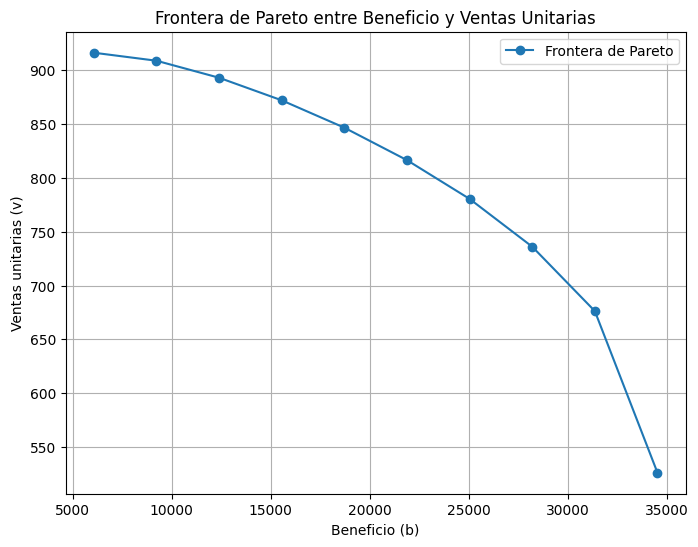

In [5]:
# Graficar la frontera de Pareto
plt.figure(figsize=(8, 6))
plt.plot(pareto[:, 0], pareto[:, 1], '-o', label="Frontera de Pareto")
plt.xlabel('Beneficio (b)')
plt.ylabel('Ventas unitarias (v)')
plt.title('Frontera de Pareto entre Beneficio y Ventas Unitarias')
plt.legend()
plt.grid(True)
plt.show()

Supongamos que la empresa startup ahora decide que, aunque ambos objetivos son importantes, maximizar el número de unidades vendidas es más importante que maximizar el beneficio. ¿Qué sugerencias le darías a la empresa basándote en tus resultados de las partes (b) y (c)?

Basandonos en la parte b y c, podríamos decir que depende qué tanto más importante es el beneficio. Si el beneficio es todo lo que nos importa, podemos usar el maximo que encontramos en la sección donde calculamos los maximos y minimos de beneficio, que en el diagrama de pareto es el punto que está más a la derecha del diagrama. Para otros casos en los cuales es más importante el beneficio (pero no queremos ignorar por completo las ventas unitarias), le diría al startup que es de suma importancia encontrar un punto sobre la frontera de pareto, que representa los diferentes maximos que encontramos al maximizar nuestra función dandole diferentes niveles de importancia al beneficio y a las ventas unitarias. En resumidas cuentas, le diría que seleccione un punto sobre la frontera de pareto dependiendo de qué tanta importancia le da al beneficio.